## Stock Market Prediction with Machine Learning 

**Objectives:**

* To create a machine learning model that can predict the following day's S&P index price given historical data
* To back test the model on 20+ years of historical data

## Workflow
Here are the steps taken when doing this project:
1. [Importing libraries](#libraries)
2. [Download S&P 500 Price data](#data-download)
3. [Data Cleaning and visualization](#cleaning)
4. [Setting up the target for ML](#target-setup)
5. [Training an initial ML model](#initial-model)
6. [Building a Backtesting system](#backtest)

<a name="libraries"></a>
### 1. Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn

%matplotlib inline
pd.set_option("display.max_columns", 50)

### 2. Download S&P 500 Price data

First import the `yfinance` package, that calls the Yahoo Finance API to download daily stock and index prices

In [2]:
import yfinance as yf

[Helpful Read](https://medium.com/@kasperjuunge/yfinance-10-ways-to-get-stock-data-with-python-6677f49e8282)\
The `Ticker` class allows you to to access various data for a specific stock.\
In our case, it will enable us to download the price history for a single symbol,the **^GSPC** for the S&P500 index.

In [3]:
# initializing the Ticker class
sp500 = yf.Ticker("^GSPC")

In [4]:
# querying the history using history() method
sp500 = sp500.history(period="max")

^GSPC: No price data found, symbol may be delisted (1d 1925-03-25 -> 2024-03-01)


In [5]:
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In the dataframe, each row shows the price in a single trading day, non-trading days are not included.\
Columns explained:
- Open: opening price when the market opened
- High: highest price during the day
- Low: lowest price during the day
- Close: closing price when the exchange closed
- Volume: trading volume(quantity of shares belonging to the stock) for the day
- Dividends: portion of a company's earnings paid to shareholders.
- Stock splits: when a company increases  the number of oustanding shares of stock to boost the stock's liquidity.


In [6]:
sp500.index

Index([], dtype='object', name='Date')

<a name="cleaning"></a>
### 3. Cleaning and visualizing the data

<Axes: xlabel='Date'>

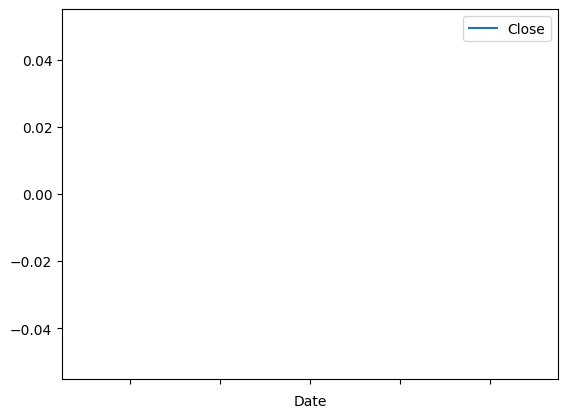

In [7]:
#plotting the closing price line chart
sp500.plot(kind="line", y="Close", use_index=True)

An interesting method to drop columns in a dataframe is using `del` to delete the column using the syntax `del df['column name']`

In [8]:
# removing the dividends and stock splits columns
del sp500["Dividends"]
del sp500["Stock Splits"]

KeyError: 'Dividends'

In [ ]:
sp500

<a name="target-setup"></a>
### 4. Set up the target for ML

In [ ]:
# creating a column called Tomorrow(tomorrow's price) using shift method 
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500

Shifting a column is moving its values up and down by a certain number of rows.This is achieved in pandas using the `shift()` function. The function takes a single argument, that is the number of rows to shift the column by.\
If the arguments are positive, the column values are shifted downwards, if negative, the values are shifted upwards.\
In our case, the Close column prices were shifted back one day(by one row) to form the Tomorrow column.This enables us to create a column that shows tomorrow's price based on the future closing prices!😃

In [ ]:
# using Tomorrow column to set up the target
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

Output is a boolean indicating whether tomorrow's price is greater than today's price\
It's a `1` when the price is `higher`(price increased) and a `O` when the price is `lower`(price decreased)

In [ ]:
sp500

In [ ]:
# choosing only data that came after 1990
sp500 = sp500.loc["1990-01-01":].copy()
sp500

<a name="initial-model"></a>
### 5. Training an initial ML model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# creating instance of the class
rand_model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)


In [ ]:
sp500.shape

In [ ]:
sp500.columns

In [ ]:
# splitting the data into train and test sets

# training set has all of the rows except the last 100
train_set = sp500.iloc[:-100]
# test data=last 100 rows
test_set = sp500.iloc[-100:]

#features
features = ['Open', 'High', 'Low', 'Close', 'Volume']

When dealing with time series data, it's advisable not to use crossvalidation or any other splitting method that doesn't consider the time series nature of the data.This is because you will be using future data to predict the past, which is impractical, and will result in leakage(leaking information into the model).

In [ ]:
# fiting the model
rand_model.fit(train_set[features], train_set["Target"])

Since I'm familiar with the usual `train_test_split()` method, this is how I interpret the train and test sets for better understanding:
```python
X_train = train_set[features]
y_train = train_set["Target"]
X_test = test-set[features]
y_test = test_set["Target"]
```


In [ ]:
# predicting
predicts = rand_model.predict(test_set[features])

In [ ]:
predicts

In [ ]:
# Turning predicts fron numpy array to pandas series
predicts = pd.Series(data=predicts, index = test_set.index )

In [ ]:
predicts

In [ ]:
# evaluating model using precision score
from sklearn.metrics import precision_score

precision_score(test_set["Target"], predicts)

Precision tells us what percentage of the model's predictions were correct.\
In this model, only ~54% of the predictions were true.

In [ ]:
# combining actual values (test_set["Target"]) and the predicted  values predicts
combined = pd.concat([test_set["Target"], predicts], axis=1)

In [ ]:
combined.head()

In [ ]:
combined.plot()

The orange lines(0) are the model's predictions and the blue lines are what actually happened.\
The model mostly(from the start of 2024 onwards) predicted the prices to have gone down, which was not the case.


<a name="backtest"></a>
### 6. Building a Backtesting system

Backtesting involves applying a strategy or predictive model to historical data to determine its accuracy.\
The theory is that if their strategy performed poorly in the past, it is unlikely to perform well in the future (and vice versa)

In [ ]:
# create a prediction function that fits and predicts
def predict(train_set, test_set, features, rand_model):
    rand_model.fit(train_set[features], train_set["Target"])
    predicts = rand_model.predict(test_set[features])
    predicts = pd.Series(data=predicts, index = test_set.index, name="Predictions")
    combined = pd.concat([test_set["Target"], predicts], axis=1)
    return combined
    

In [ ]:
# create a backtesting function
def backtest(data, rand_model, features, start=2500, step=250):
    all_predictions = [] # list of dataframes, where each dataframe is the predictions for a single year

    # looping across the data
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy() # training set is all years before current year
        test = data.iloc[i:(i+step)].copy() # test set is the current year
        predictions = predict(train,test, features,rand_model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)
    

During backtesting, one takes a certain amount of data to train the first model.\
Every trading year has around 250 days.To train the **first** model with ten years of data, it requires us to start at an index of 2500 (250x10).\
What is happening is that the model is initially using the first 10 years of data to train and then predict values for the 11th year.Then takes values for the first 11 years and use it to predict the 12th year, first 12 years of data and predict values for the 13th year...\
Here is how the loop works:\
`for i in range(start, data.shape[0], step):` Here the for loop is 'initialised' at 2500 index and then incremented in steps of 250 upto the value of the total rows in the dataframe.\
`train = data.iloc[:i].copy()`, the training data is all data before the current index (i)/day\
`test = data.iloc[i:(i+step)].copy()`, the test data is all data from the current index(i)/day to the next 250 days, which is equivalent to 1 trading year from current day\
`predictions = predict(train, test, features, rand_model)` calling the predict function previously created and assigning output to predictions\
`all_predictions.append(predictions)` appending the all_predictions list with the trading year's prediction


In [ ]:
prediction = backtest(sp500, rand_model, features)